In [7]:
# Step9 - Benchmarking Tuned Models (Final Fixed, Warnings Removed)

import os, time, warnings
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

# ---------------------------
# Silence warnings globally
# ---------------------------
warnings.filterwarnings("ignore")
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # silence joblib loky CPU count warning

# ---------------------------
# Paths
# ---------------------------
PROJECT_ROOT = r"C:\Users\uthay\Desktop\CyberThreats_FinancialLoss_Prediction_ML"
MODEL_PATH = os.path.join(PROJECT_ROOT, "models")
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "Global_Cybersecurity_Threats_2015-2024 (1).csv")
REPORT_PATH = os.path.join(PROJECT_ROOT, "reports")
os.makedirs(REPORT_PATH, exist_ok=True)

# ---------------------------
# Load and preprocess dataset
# ---------------------------
df = pd.read_csv(RAW_DATA_PATH)

df['AttackType_TargetIndustry'] = df['Attack Type'] + "_" + df['Target Industry']
df['Loss_per_User'] = df['Financial Loss (in Million $)'] / (df['Number of Affected Users'] + 1)

numeric_features = ['Number of Affected Users', 'Incident Resolution Time (in Hours)', 'Loss_per_User']
categorical_features = ['Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type', 'AttackType_TargetIndustry']
target = 'Financial Loss (in Million $)'

X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# Tuned models (ExtraTrees removed)
# ---------------------------
models = {
    "CatBoost": "CatBoost_tuned.joblib",
    "LightGBM": "LightGBM_tuned.joblib",
    "RandomForest": "RandomForest_tuned.joblib",
    "GradientBoosting": "GradientBoosting_tuned.joblib",
    "XGBoost": "XGBoost_tuned.joblib"
}

results = []

# ---------------------------
# Evaluation loop
# ---------------------------
for name, fname in models.items():
    try:
        model = joblib.load(os.path.join(MODEL_PATH, fname))

        # Train metrics
        y_train_pred = model.predict(X_train)
        r2_train = r2_score(y_train, y_train_pred)
        rmse_train = mean_squared_error(y_train, y_train_pred) ** 0.5
        mae_train = mean_absolute_error(y_train, y_train_pred)

        # Test metrics
        start = time.time()
        y_test_pred = model.predict(X_test)
        inference_time = time.time() - start

        r2_test = r2_score(y_test, y_test_pred)
        rmse_test = mean_squared_error(y_test, y_test_pred) ** 0.5
        mae_test = mean_absolute_error(y_test, y_test_pred)

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)

        results.append({
            "Model": name,
            "R2_Train": r2_train,
            "R2_Test": r2_test,
            "RMSE_Train": rmse_train,
            "RMSE_Test": rmse_test,
            "MAE_Train": mae_train,
            "MAE_Test": mae_test,
            "CV_R2_Mean": cv_mean,
            "CV_R2_Std": cv_std,
            "Inference_Time_sec": inference_time
        })

    except Exception as e:
        print(f"[Error] {name}: {e}")

# ---------------------------
# Results summary
# ---------------------------
results_df = pd.DataFrame(results)

if not results_df.empty:
    results_df = results_df.set_index("Model").sort_values("R2_Test", ascending=False)
    results_df.to_csv(os.path.join(REPORT_PATH, "model_benchmarking_results_with_cv.csv"))

    print("\n📊 Model Benchmarking Results:\n")
    print(results_df)

    best_model = results_df["R2_Test"].idxmax()
    print(f"\n🏆 Best model based on Test R²: {best_model}")

    # Diagnostics
    for model in results_df.index:
        train_r2 = results_df.loc[model, "R2_Train"]
        test_r2 = results_df.loc[model, "R2_Test"]
        cv_mean = results_df.loc[model, "CV_R2_Mean"]

        print(f"\n🔎 {model}: Train R²={train_r2:.3f}, Test R²={test_r2:.3f}, CV Mean R²={cv_mean:.3f}")
        if train_r2 - test_r2 > 0.05:
            print("⚠️ Possible overfitting.")
        elif test_r2 - cv_mean > 0.05:
            print("⚠️ Test R² much higher than CV — possible data leakage.")
        else:
            print("✅ Generalization looks good.")
else:
    print("⚠️ No models evaluated successfully. Check file names and paths.")


📊 Model Benchmarking Results:

                  R2_Train   R2_Test  RMSE_Train  RMSE_Test  MAE_Train  \
Model                                                                    
LightGBM          0.993084  0.984537    2.401161   3.536036   1.015148   
XGBoost           0.999801  0.980211    0.407423   4.000288   0.298950   
GradientBoosting  0.995870  0.977171    1.855609   4.296564   1.376276   
CatBoost          0.998892  0.973099    0.961094   4.664047   0.732986   
RandomForest      0.989274  0.971994    2.990235   4.758871   1.119330   

                  MAE_Test  CV_R2_Mean  CV_R2_Std  Inference_Time_sec  
Model                                                                  
LightGBM          1.642534    0.985253   0.004440            0.021842  
XGBoost           1.532552    0.984951   0.005316            0.016704  
GradientBoosting  2.149020    0.981284   0.006167            0.016889  
CatBoost          1.960262    0.978614   0.003824            0.042109  
RandomForest     

<Figure size 1000x600 with 0 Axes>

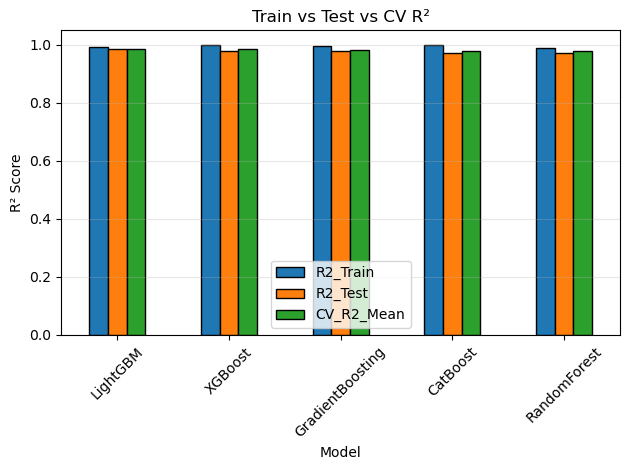

In [8]:
# Visualizations
# ---------------------------

# Graph 1: Train vs Test vs CV R²
plt.figure(figsize=(10, 6))
results_df[["R2_Train", "R2_Test", "CV_R2_Mean"]].plot(kind="bar", edgecolor="black")
plt.title("Train vs Test vs CV R²")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(REPORT_PATH, "R2_comparison.png"))
plt.show()


<Figure size 1000x600 with 0 Axes>

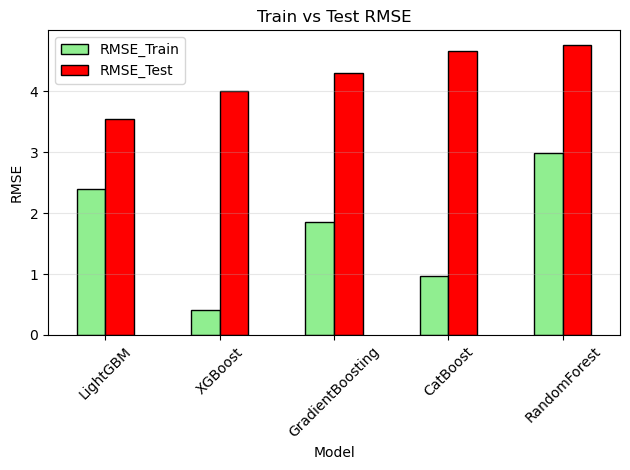

In [9]:
# Graph 2: Train vs Test RMSE
plt.figure(figsize=(10, 6))
results_df[["RMSE_Train", "RMSE_Test"]].plot(kind="bar", edgecolor="black", color=["lightgreen", "red"])
plt.title("Train vs Test RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(REPORT_PATH, "RMSE_comparison.png"))
plt.show()


<Figure size 1000x600 with 0 Axes>

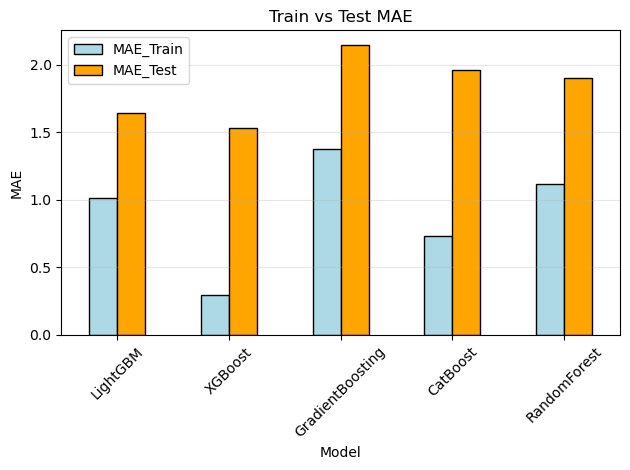

In [10]:
# Graph 3: Train vs Test MAE
plt.figure(figsize=(10, 6))
results_df[["MAE_Train", "MAE_Test"]].plot(kind="bar", edgecolor="black", color=["lightblue", "orange"])
plt.title("Train vs Test MAE")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(REPORT_PATH, "MAE_comparison.png"))
plt.show()


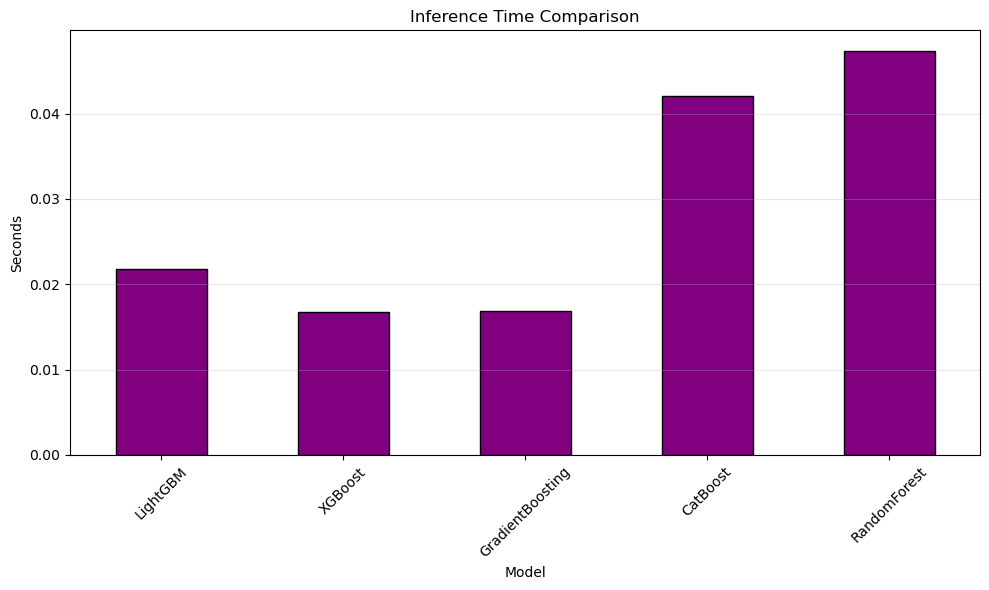

In [11]:
# Graph 4: Inference Time Comparison
plt.figure(figsize=(10, 6))
results_df["Inference_Time_sec"].plot(kind="bar", edgecolor="black", color="purple")
plt.title("Inference Time Comparison")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(REPORT_PATH, "InferenceTime_comparison.png"))  # fixed filename
plt.show()
